In [15]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

In [2]:
# Suppress specific future warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")

In [3]:
# Load data
characteristics = pd.read_csv('source/characteristics.csv')
locations = pd.read_csv('source/locations.csv')
users = pd.read_csv('source/users.csv')
vehicles = pd.read_csv('source/vehicles.csv')

In [4]:
# Merge dataframes on AccID
data = characteristics.merge(locations, on='AccID').merge(users, on='AccID').merge(vehicles, on='AccID')

In [5]:
# Display the columns of the merged dataframe
print("Columns in the merged dataframe:", data.columns)

Columns in the merged dataframe: Index(['AccID', 'day', 'month', 'year', 'time', 'lum', 'dep_code', 'com_code',
       'location', 'int', 'atm_condition', 'collision_type', 'address', 'lat',
       'long', 'route_category', 'route_number', 'route_number_index1',
       'alph_route_index', 'traffic_regime', 'total_number_lanes',
       'reserved_lane_code', 'longitudinal_profile',
       'upstream_terminal_number', 'distance_upstream_terminal', 'plan',
       'width_central_reservation', 'width_roadway', 'surface_condition',
       'infra', 'accident_situation', 'maximum_speed', 'vehicleID_x',
       'num_veh_x', 'seat', 'user_category', 'gravity', 'gender', 'birth_year',
       'reason_travel', 'safety_equipment1', 'safety_equipment2',
       'safety_equipment3', 'pedestrian_location', 'pedestrian_action',
       'pedestrian_involved', 'age', 'vehicleID_y', 'num_veh_y',
       'traffic_direction', 'vehicle_category', 'fixed_obstacle',
       'mobile_obstacle', 'initial_impact_point', '

In [6]:
# Update the feature columns based on the available columns in the dataframe
feature_cols = ['time', 'lum', 'atm_condition', 'vehicle_category', 'age', 'traffic_regime', 'route_category']
target_col = 'gravity'

In [7]:
# Convert time column to a numerical format (e.g., seconds since midnight)
data['time'] = pd.to_datetime(data['time'], format='%H:%M:%S').dt.hour * 3600 + pd.to_datetime(data['time'], format='%H:%M:%S').dt.minute * 60 + pd.to_datetime(data['time'], format='%H:%M:%S').dt.second

In [8]:
# Handle missing values before splitting the data
imputer = SimpleImputer(strategy='median')
data[feature_cols] = imputer.fit_transform(data[feature_cols])

In [9]:
# Ensure stratified split
X = data[feature_cols]
y = data[target_col]

In [10]:
# Check class distribution before split
print("Class distribution in the dataset before split:\n", y.value_counts())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Class distribution in the dataset before split:
 gravity
 1    427314
 4    369753
 3    124268
 2     20169
-1       565
Name: count, dtype: int64


In [11]:
# Check class distribution after split
print("Class distribution in the training set:\n", y_train.value_counts())
print("Class distribution in the test set:\n", y_test.value_counts())

Class distribution in the training set:
 gravity
 1    341851
 4    295802
 3     99415
 2     16135
-1       452
Name: count, dtype: int64
Class distribution in the test set:
 gravity
 1    85463
 4    73951
 3    24853
 2     4034
-1      113
Name: count, dtype: int64


In [12]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [13]:
# Preprocessing pipeline
numeric_features = ['age', 'time']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_features = ['lum', 'atm_condition', 'vehicle_category', 'traffic_regime', 'route_category']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [16]:
# Example model pipeline with increased max_iter
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', OneVsRestClassifier(LogisticRegression(max_iter=2000, class_weight='balanced')))])

In [17]:
# Train model
model.fit(X_train_smote, y_train_smote)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'time']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['lum', 'atm_condition',
                                                   'vehicle_category',
                                                   'traffic_regime',
                                                   'route_category'])])),
                ('classifier',
                 OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                                  max_iter=2000)))])

In [18]:
# Predict and evaluate model
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

          -1       0.01      0.09      0.02       113
           1       0.50      0.56      0.53     85463
           2       0.09      0.18      0.12      4034
           3       0.23      0.25      0.24     24853
           4       0.47      0.36      0.41     73951

    accuracy                           0.43    188414
   macro avg       0.26      0.29      0.26    188414
weighted avg       0.44      0.43      0.43    188414

Confusion Matrix:
 [[   10    48     1    18    36]
 [  327 47952  2785 10966 23433]
 [   14  1799   719   897   605]
 [   98 10669  2220  6239  5627]
 [  388 36249  2230  8734 26350]]


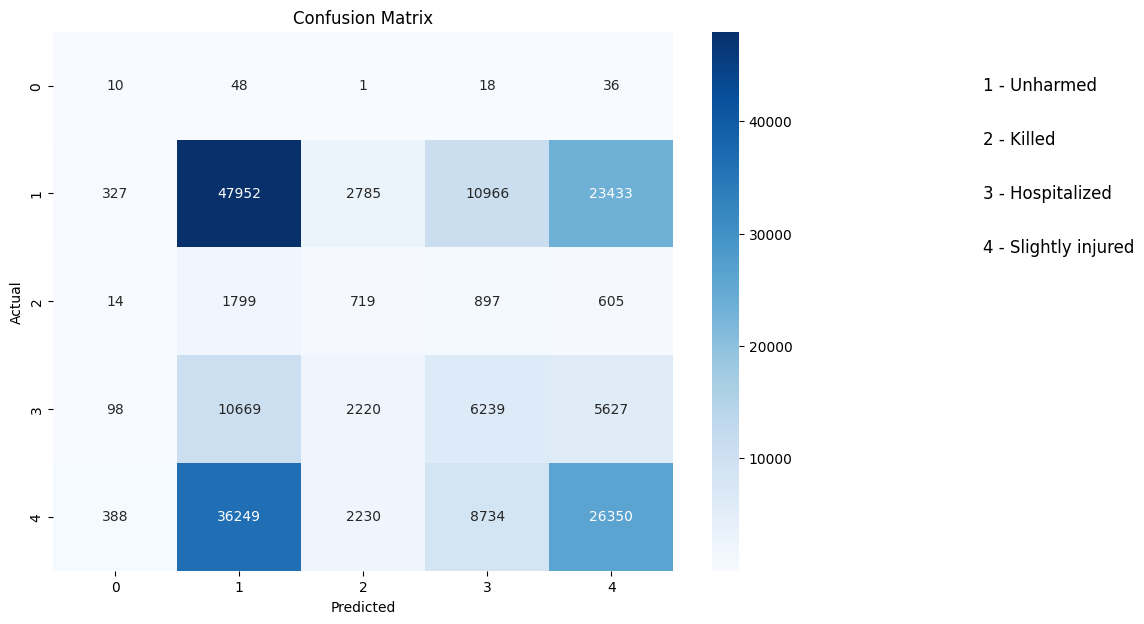

In [24]:
# Confusion Matrix Heatmap
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Adding a custom legend
plt.text(7.5, 0.5, '1 - Unharmed', verticalalignment='center', color='black', fontsize=12)
plt.text(7.5, 1.0, '2 - Killed', verticalalignment='center', color='black', fontsize=12)
plt.text(7.5, 1.5, '3 - Hospitalized', verticalalignment='center', color='black', fontsize=12)
plt.text(7.5, 2.0, '4 - Slightly injured', verticalalignment='center', color='black', fontsize=12)

plt.show()

In [25]:
# Function to check and replace inf values with NaN
def replace_inf_with_nan(arr):
    return np.where(np.isinf(arr), np.nan, arr)

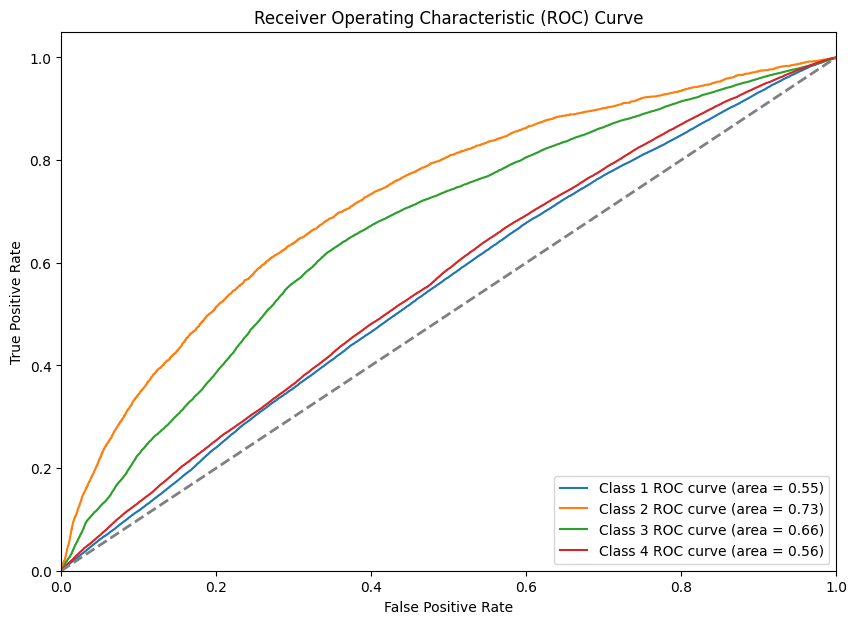

In [26]:
# ROC Curve for each class using Seaborn
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(set(y_test))

# Binarize the output
y_test_bin = label_binarize(y_test, classes=[*range(n_classes)])

for i in range(n_classes):
    if y_test_bin[:, i].sum() == 0:
        continue  # Skip the class if there are no positive samples in y_test
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    fpr[i] = replace_inf_with_nan(fpr[i])
    tpr[i] = replace_inf_with_nan(tpr[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10,7))
for i in range(n_classes):
    if i in roc_auc:
        sns.lineplot(x=fpr[i], y=tpr[i], label=f'Class {i} ROC curve (area = {roc_auc[i]:0.2f})')
sns.lineplot(x=[0, 1], y=[0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

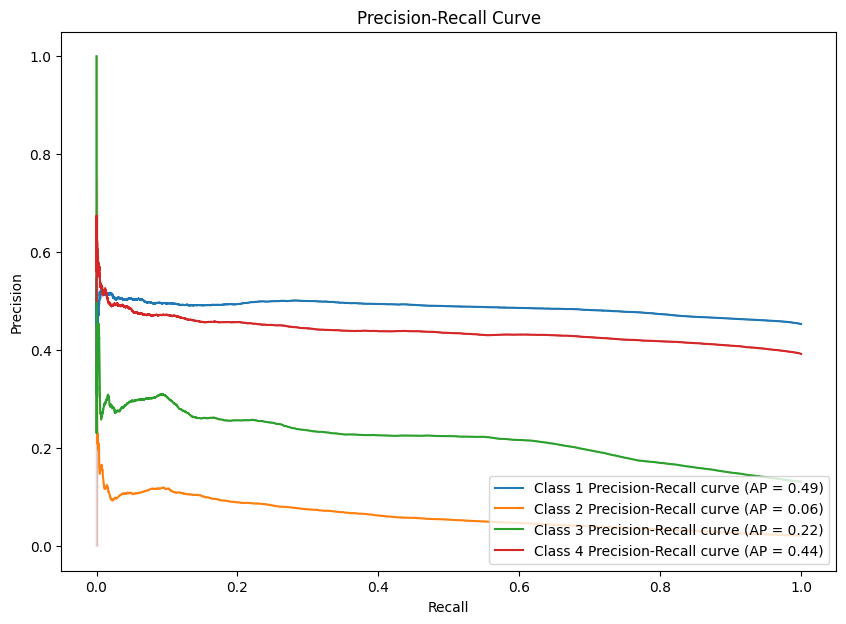

In [27]:
# Precision-Recall Curve for each class using Seaborn
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    if y_test_bin[:, i].sum() == 0:
        continue  # Skip the class if there are no positive samples in y_test
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_pred_proba[:, i])
    precision[i] = replace_inf_with_nan(precision[i])
    recall[i] = replace_inf_with_nan(recall[i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_pred_proba[:, i])

plt.figure(figsize=(10,7))
for i in range(n_classes):
    if i in precision:
        sns.lineplot(x=recall[i], y=precision[i], label=f'Class {i} Precision-Recall curve (AP = {average_precision[i]:0.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()